In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from func import ImageData, CollateFn, CollateSingleImage, ImageOriginalData, Model, clip_loss, LightningModel
from lightning import Trainer, seed_everything
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms, io

seed_everything(42)

Global seed set to 42


42

In [2]:
path = Path.home() / 'OneDrive - Seagroup/ai/computer_vison/coco/coco2017/train2017'
files = [str(file) for file in path.glob("*.jpg")]
train_files, valid_files = train_test_split(files, test_size=0.15, random_state=42)

BATCH_SIZE = 32
train_data = ImageData(train_files)
train_dl = DataLoader(
    train_data,
    BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=CollateFn(),
)

valid_data = ImageOriginalData(valid_files)
valid_dl = DataLoader(
    valid_data,
    BATCH_SIZE*2,
    shuffle=False,
    drop_last=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=CollateSingleImage(),
)

In [5]:
train_data[0][0].shape

torch.Size([3, 256, 256])

In [3]:
N_HEADS = 8
N_LAYERS = 6
PATCH_SIZE = 16
ZERO_PCT = 0.1
IMAGE_SIZE = 256
PATCHES_PER_ROW = (IMAGE_SIZE // PATCH_SIZE)
NUM_PATCHES = PATCHES_PER_ROW ** 2
RGB_CHANNELS = 3
NUM_PIXELS = PATCH_SIZE ** 2 * RGB_CHANNELS
TEMPERATURE_S = 0.1
TEMPERATURE_T = 0.05
CENTER_MOMENTUM = 0.9
TEACHER_MOMENTUM = 0.995
LR = 1e-4
EPOCHS = 3

# model_checkpoint = ModelCheckpoint(dirpath='clip/',
#                                    save_top_k=1,
#                                    monitor="valid_loss",
#                                    mode="min",)
lr_monitor = LearningRateMonitor(logging_interval='step')

teacher = Model(NUM_PIXELS, N_HEADS, N_LAYERS)
# h_loss = HLoss(TEMPERATURE_T, TEMPERATURE_S)
lightning_model = LightningModel(
    teacher,
    LR,
    clip_loss,
    valid_files,
)

trainer = Trainer(
    accelerator='gpu',
    max_epochs=EPOCHS,
    gradient_clip_val=1.0,
    precision=16,
    num_sanity_val_steps=0,
    deterministic=True,
    callbacks=[lr_monitor],
)
trainer.fit(lightning_model, train_dl, valid_dl)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance.

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [4]:
image_orig_data = ImageOriginalData(files)
image_orig_dl = DataLoader(
    image_orig_data,
    BATCH_SIZE*2,
    shuffle=False,
    drop_last=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=CollateSingleImage(),
)

device = 'cuda'
teacher = teacher.eval().to(device)
embedding = []
with torch.no_grad():
    for x in tqdm(image_orig_dl):
        out = teacher(x.to(device))
        embedding.append(out.cpu())

    embedding = torch.cat(embedding, dim=0)

100%|██████████████████████████████████████████████████████████████████████████████| 1849/1849 [07:29<00:00,  4.12it/s]


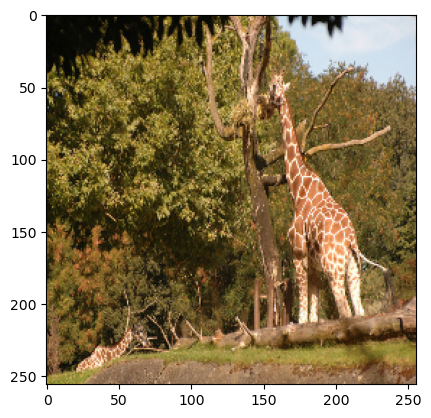

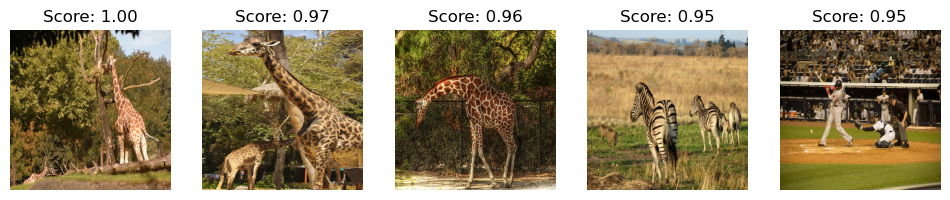

In [25]:
resize = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))


def get_closest(embedding: torch.FloatTensor, i: int):
    similarity = embedding @ embedding[i,:].T
    scores, idx = similarity.topk(5)
    return scores, idx


def plot_closest_pairs(embedding, i, files):
    img = to_pil_image(resize(io.read_image(files[i])))
    plt.imshow(img)
    scores, idx = get_closest(embedding, i)
    
    fig, axs = plt.subplots(1, len(idx), figsize=(12, 5))
    for i, score, ax in zip(idx, scores, axs):
        img = to_pil_image(resize(io.read_image(files[i])))
        ax.imshow(img)
        ax.set_title(f"Score: {score:.2f}")
        ax.axis('off')

    plt.show()
    
    
i = 1
plot_closest_pairs(embedding, i, files)